In [92]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram



In [93]:
#get the data sets
train_df = pd.read_csv('train_set.csv')

In [94]:
#drop the empty column at the beginning
train_df = train_df.drop('Unnamed: 0',axis = 1)

In [176]:
#make the categorical columns into numeric
train_df_encoded = pd.get_dummies(train_df, columns=['language',	'emotion',	'gender'])

In [96]:
#remove unneeded columns and set y column
columns = [column for column in train_df_encoded.columns if 'file_name' != column and 'duration' != column and 'emotion_' not in column ]
pred_column = 'emotion_SAD'


In [97]:
#Separate out the prediction column. Remove the text column (can't standardize text) as well as the coded emotions.
droplist_base= ['file_name']+[column for column in train_df_encoded.columns if 'emotion_' in column]

Xtrain = train_df_encoded.drop(droplist_base, axis=1)
Ytrain = train_df_encoded[pred_column]

#Scale the predictors
scaler = StandardScaler()
Xtrain_scaled_array = scaler.fit_transform(Xtrain)

#Put them back into a dataframe for use
Xtrain_scaled = pd.DataFrame(Xtrain_scaled_array, columns=Xtrain.columns)

KNN

In [110]:
k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(Xtrain_scaled)

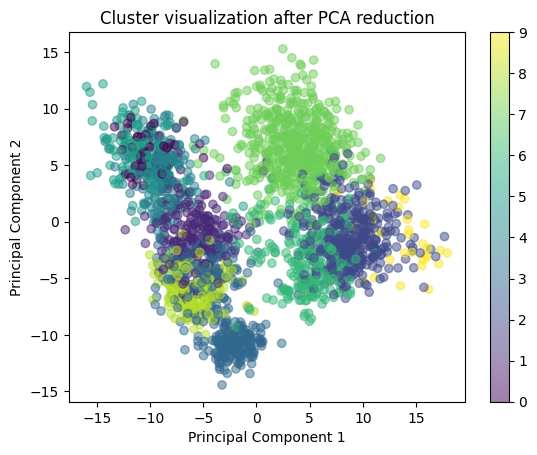

In [111]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(Xtrain_scaled)

plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', marker='o', alpha=0.5)
plt.colorbar()
plt.title('Cluster visualization after PCA reduction')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [112]:
train_df['cluster'] = clusters
train_df[train_df['cluster'] == 0][['language', 'emotion', 'gender']].value_counts()
# cluster 0 is mostly English, happy, and female

language  emotion  gender
ENG       HAP      F         73
FRE       HAP      M          1
dtype: int64

In [113]:
train_df[train_df['cluster'] == 3][['gender']].value_counts()
# cluster 1 is mostly English, not sad, male

gender
M         357
dtype: int64

In [114]:
train_df[train_df['cluster'] == 4][['emotion']].value_counts()
# cluster 4 is mostly female, eng, angry

emotion
ANG        171
HAP          4
SAD          1
dtype: int64

In [115]:
train_df[train_df['cluster'] == 5][['language']].value_counts()
# cluster 3 is mostly female, happy, eng

language
ENG         112
GER           1
dtype: int64

In [116]:
train_df[train_df['cluster'] == 6][['gender']].value_counts()
#eng, sad

gender
F         158
M          79
dtype: int64

In [117]:
train_df[train_df['cluster'] == 7][['emotion']].value_counts()
# german, sad

emotion
ANG        285
HAP        187
SAD         49
dtype: int64

In [118]:

centroids = kmeans.cluster_centers_
distances = np.sqrt(((Xtrain_scaled - centroids[clusters]) ** 2).sum(axis=1))

In [119]:
threshold = np.quantile(distances, 0.95)
anomalies = Xtrain_scaled[distances > threshold]

Hierarchical Clustering

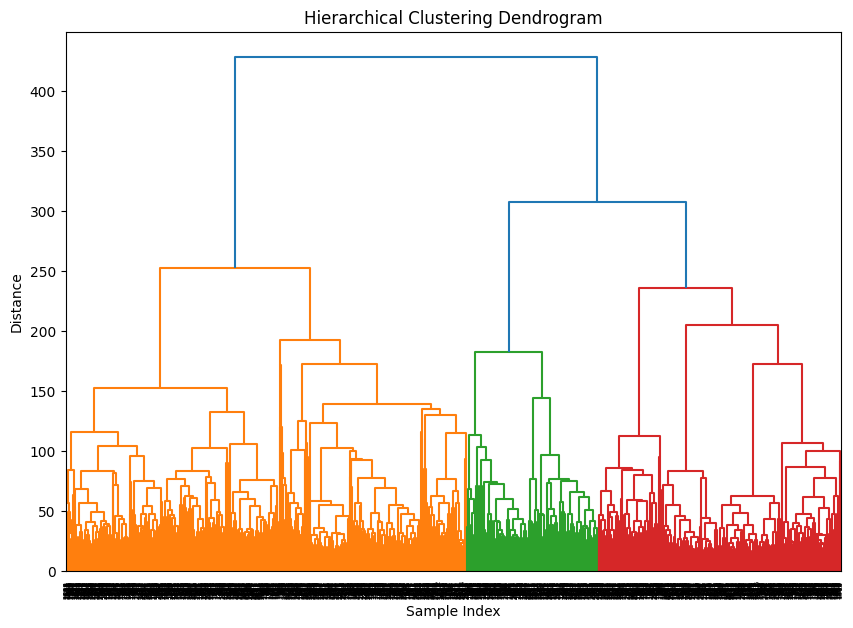

In [121]:
linkage_matrix = linkage(Xtrain_scaled, method='ward', metric='euclidean')

# Step 5: Visualizing the Clustering
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=Xtrain_scaled.index)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [195]:

from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import fcluster

# Initialize variables to store the best max_d and highest silhouette score
best_max_d = None
best_silhouette_score = -1

# Loop through a range of possible max_d values
for max_d in range(10, 240, 10):  # Adjust range and step as needed
    clusters = fcluster(linkage_matrix, max_d, criterion='distance')
    if len(set(clusters)) > 1:  # Ensure there's more than one cluster
        silhouette_avg = silhouette_score(Xtrain_scaled, clusters)
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_max_d = max_d

print(f"Best max_d: {best_max_d} with silhouette score: {best_silhouette_score}")

max_d = best_max_d  # This value depends on your dendrogram
clusters = fcluster(linkage_matrix, max_d, criterion='distance')

# Add the cluster labels to your dataframe
train_df['cluster_hierarchy'] = clusters



Best max_d: 210 with silhouette score: 0.05189716611341026


/Users/danny/Library/Python/3.9/lib/python/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/danny/Library/Python/3.9/lib/python/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


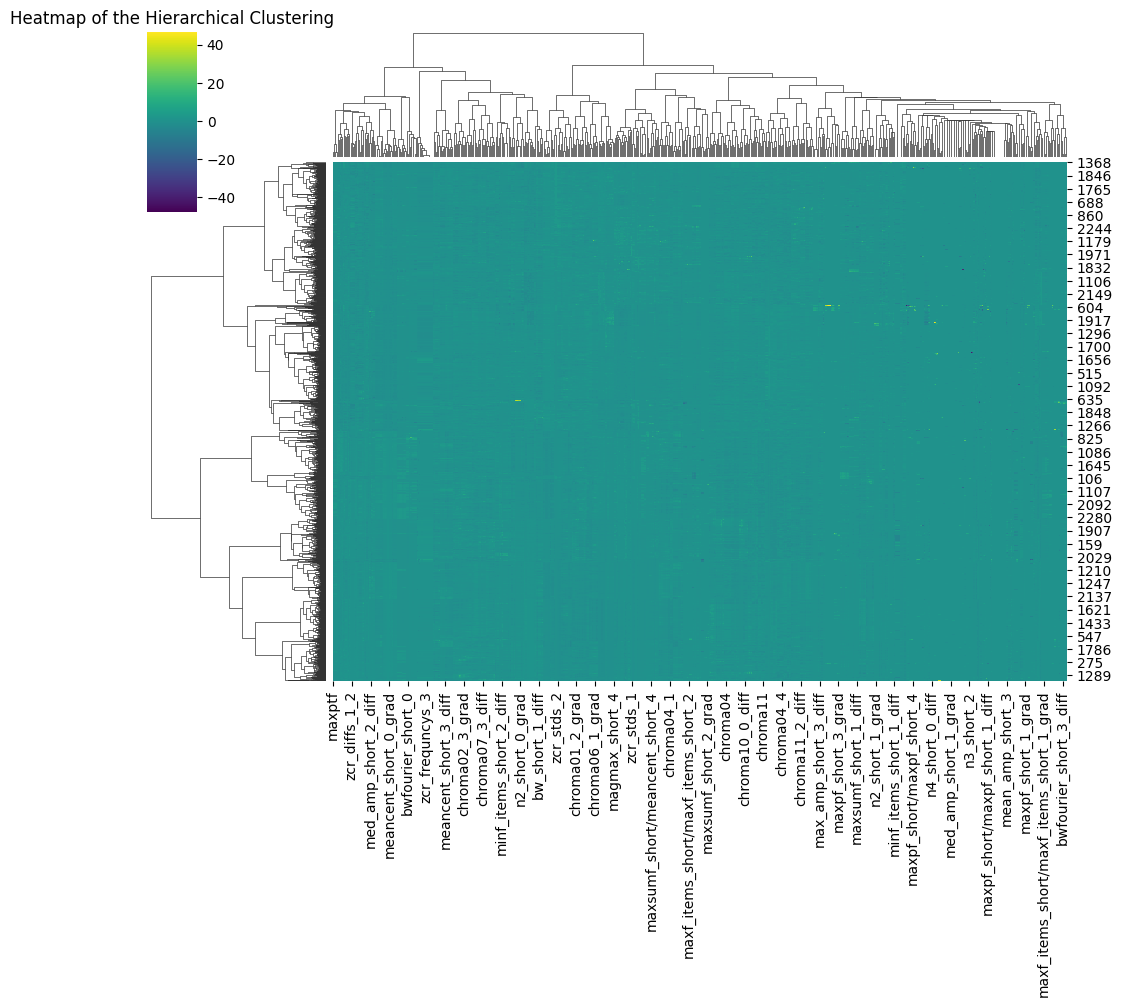

In [188]:
import seaborn as sns

# Compute the distance matrix
distance_matrix = pd.DataFrame(data=linkage_matrix, columns=['index1', 'index2', 'distance', 'num_elements'])

# Create a heatmap
sns.clustermap(Xtrain_scaled, method='ward', metric='euclidean', cmap='viridis', figsize=(10, 10))
plt.title('Heatmap of the Hierarchical Clustering')
plt.show()

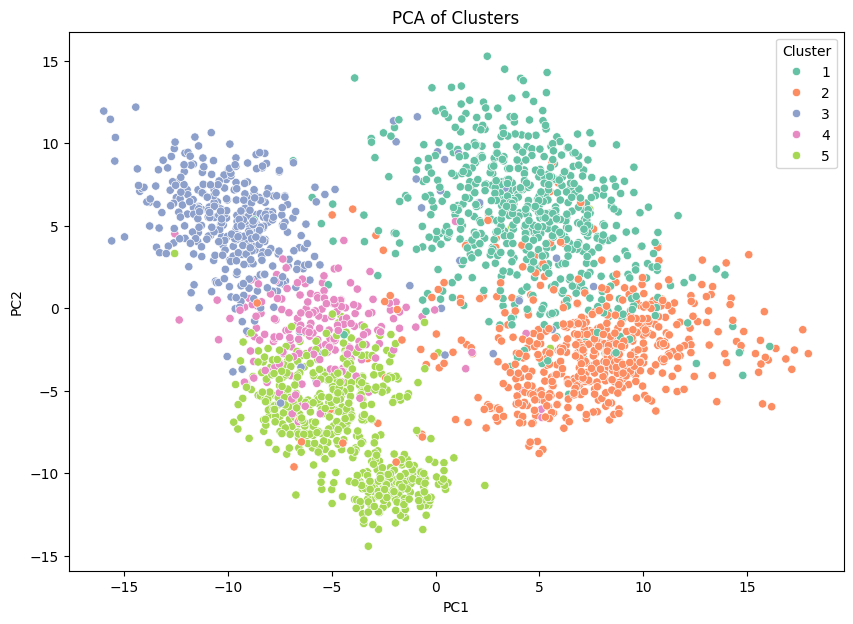

In [196]:
from sklearn.decomposition import PCA
import seaborn as sns

# Perform PCA for 2D visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(Xtrain_scaled)

# Create a DataFrame with PCA results and cluster assignments
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters

# Plot the PCA results
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set2')
plt.title('PCA of Clusters')
plt.show()

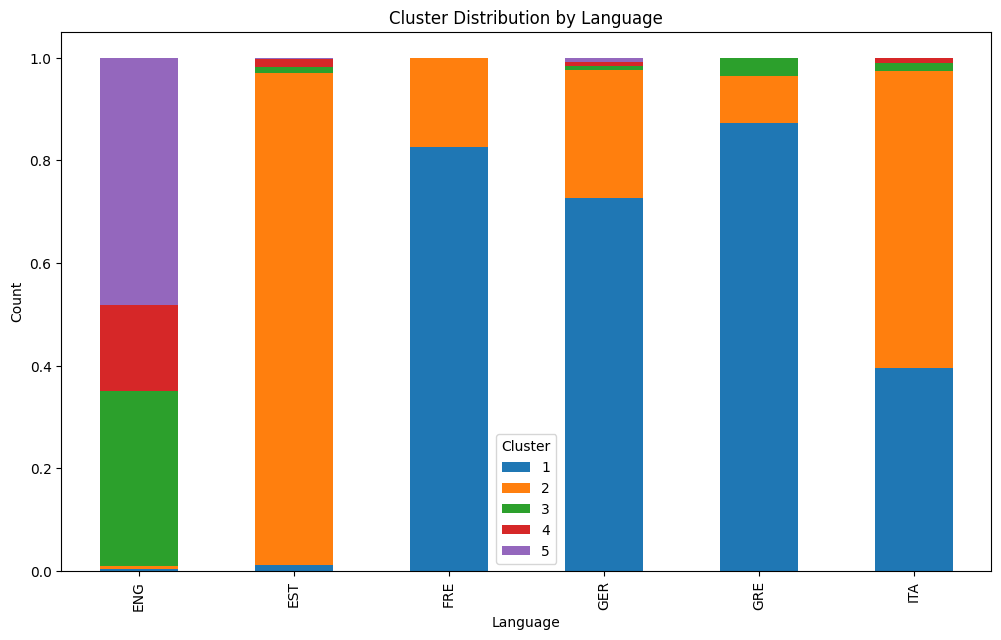

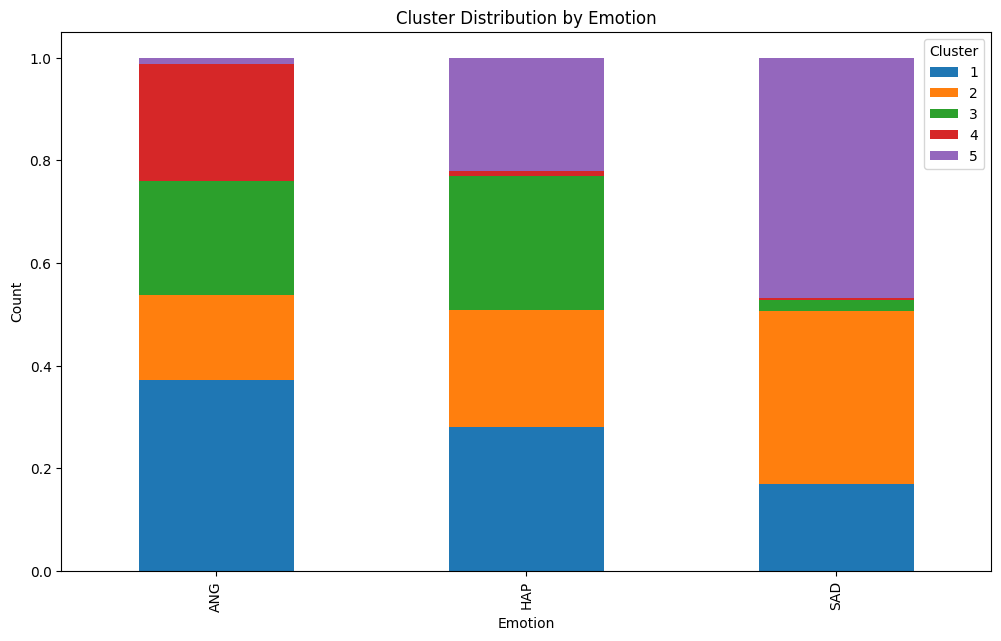

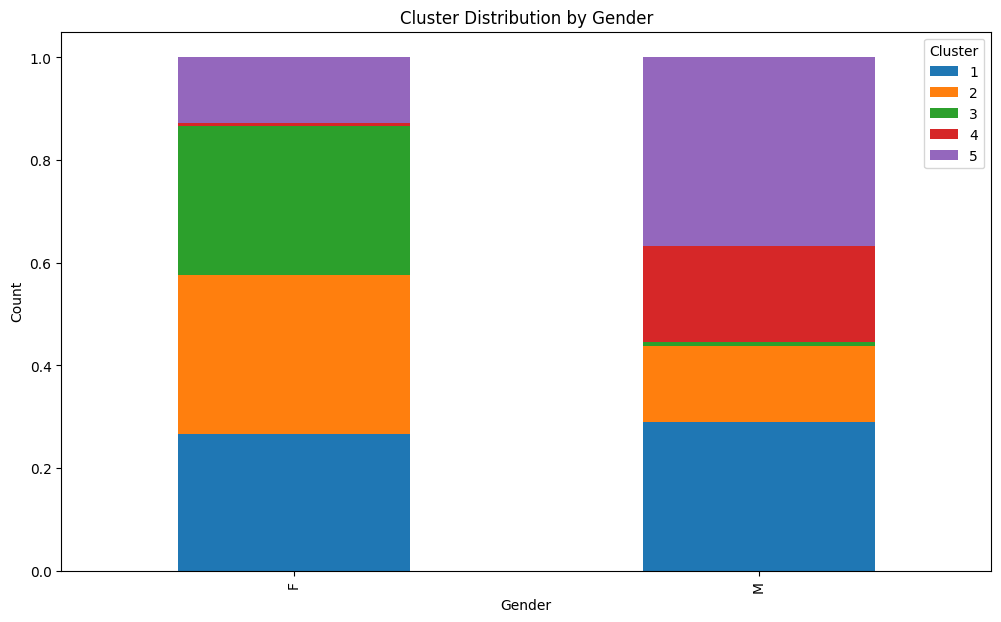

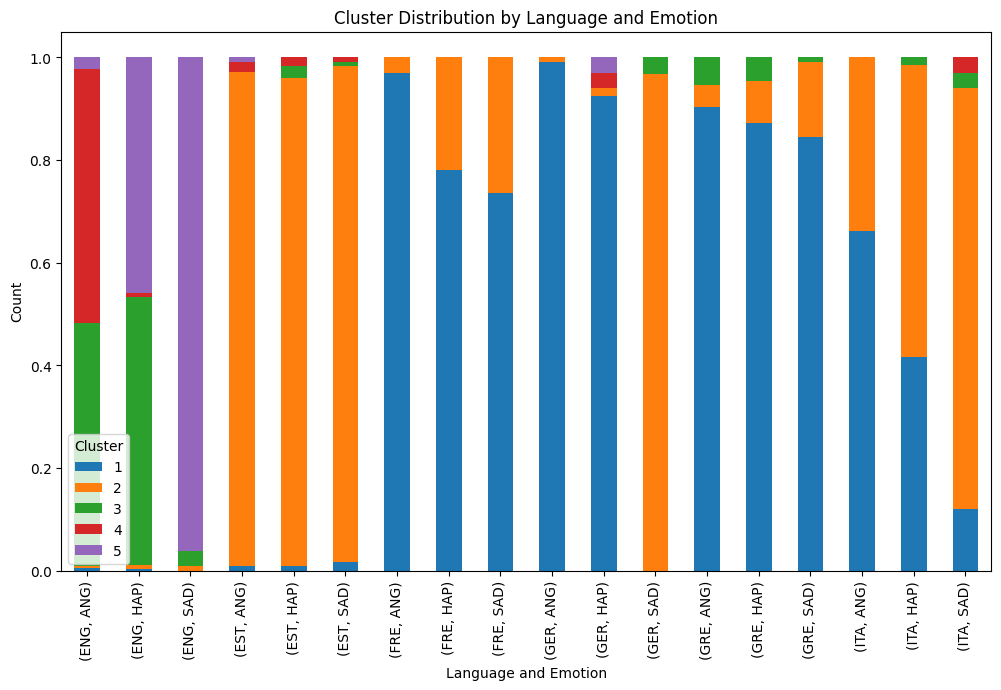

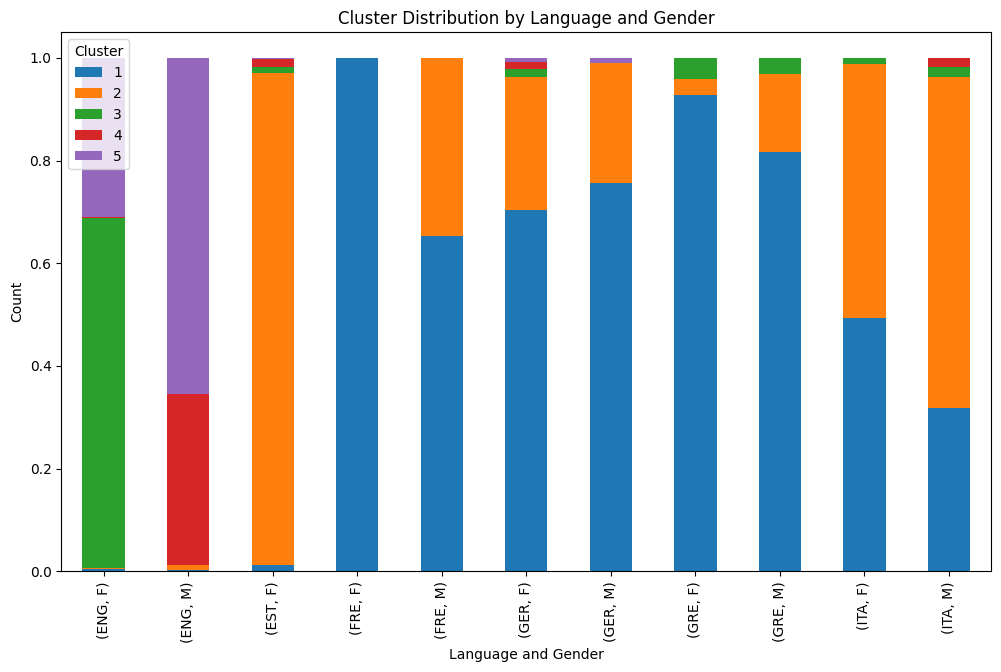

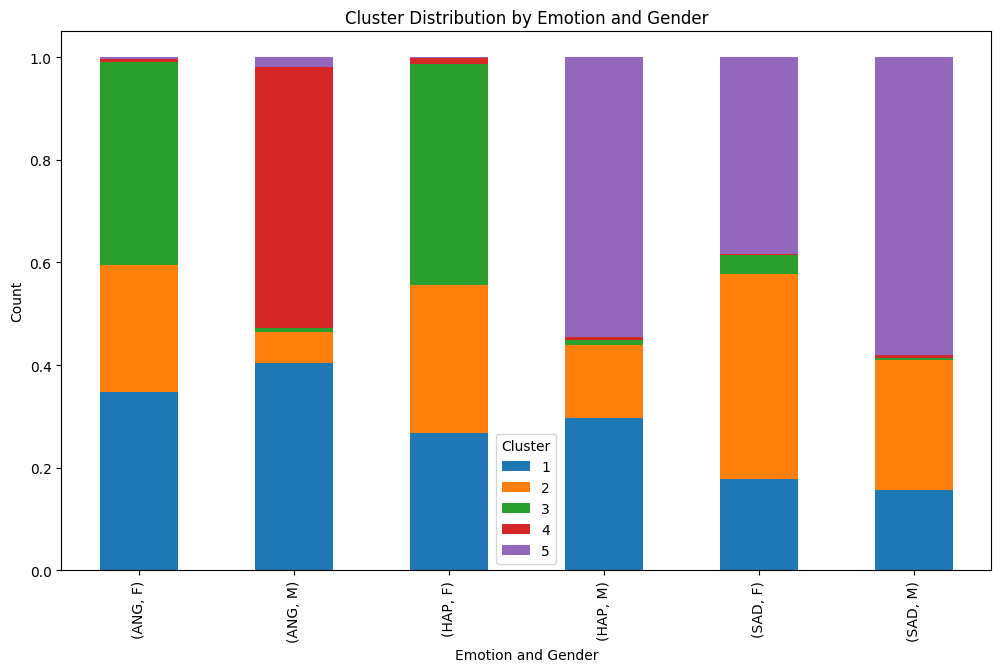

In [206]:
language_cluster_counts = (train_df.groupby(['language', 'cluster_hierarchy']).size() / train_df.groupby(['language']).size()).unstack(fill_value=0)
# Plot bar plot for language vs cluster
language_cluster_counts.plot(kind='bar', stacked=True, figsize=(12, 7))
plt.title('Cluster Distribution by Language')
plt.xlabel('Language')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.show()

# Repeat for emotion and gender
emotion_cluster_counts = (train_df.groupby(['emotion', 'cluster_hierarchy']).size() / train_df.groupby(['emotion']).size()).unstack(fill_value=0)
emotion_cluster_counts.plot(kind='bar', stacked=True, figsize=(12, 7))
plt.title('Cluster Distribution by Emotion')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.show()

gender_cluster_counts = (train_df.groupby(['gender', 'cluster_hierarchy']).size() / train_df.groupby(['gender']).size()).unstack(fill_value=0)
gender_cluster_counts.plot(kind='bar', stacked=True, figsize=(12, 7))
plt.title('Cluster Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.show()

language_cluster_counts = (train_df.groupby(['language','emotion', 'cluster_hierarchy']).size() / train_df.groupby(['language', 'emotion']).size()).unstack(fill_value=0)
# Plot bar plot for language vs cluster
language_cluster_counts.plot(kind='bar', stacked=True, figsize=(12, 7))
plt.title('Cluster Distribution by Language and Emotion')
plt.xlabel('Language and Emotion')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.show()

language_cluster_counts = (train_df.groupby(['language','gender', 'cluster_hierarchy']).size() / train_df.groupby(['language', 'gender']).size()).unstack(fill_value=0)
language_cluster_counts.plot(kind='bar', stacked=True, figsize=(12, 7))
plt.title('Cluster Distribution by Language and Gender')
plt.xlabel('Language and Gender')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.show()

emotion_gender_cluster_counts =  (train_df.groupby(['emotion','gender', 'cluster_hierarchy']).size() / train_df.groupby(['emotion', 'gender']).size()).unstack(fill_value=0)
emotion_gender_cluster_counts.plot(kind='bar', stacked=True, figsize=(12, 7))
plt.title('Cluster Distribution by Emotion and Gender')
plt.xlabel('Emotion and Gender')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.show()